# Db2 Warehouse IoT demo 
# Structured Streaming with Apache Kafka and PySpark 


This is a demo notebook for Db2 Warehouse's integrated Apache Spark environment and how it can be used to process and land streaming data in Db2 tables. It runs through livy with a PySpark kernel.

If you are new to Db2 Warehouse and its integrated Apache Spark capabilities you may first want to check out this [overview article](http://www.ibmbigdatahub.com/blog/evolving-enterprise-data-warehouse-beyond-sql-apache-spark). For more details about structured streaming and Kafka integration, please follow this [link](https://spark.apache.org/docs/2.3.0/structured-streaming-kafka-integration.html#deploying).

![](https://ibm.box.com/shared/static/6dr6gou6xr1alfwnj6zkj0tbsyc64vda.png)

## Set up IoT demo data producer
This demo relies on a little data producer container that you have to set up on the same host as your Db2 Warehouse container. You can find it [here](https://github.com/ibmdbanalytics/dashdb_analytic_tools/tree/notebook-dev/dashdblocal_notebooks/iot_producer) in a sub folder of the dashDB Jupyter notebook container project. Please follow the instructions found there and perform the few simple steps to set it up. 

This producer will set up a Kafka server on port `9092` with a Kafka topic named `iot4dashdb` and permanently flow in there messages about wind turbine device measurements.

## Streaming environment setup for Spark

__Imports__

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession 
from pyspark.sql.functions import from_json
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, LongType, TimestampType

from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from ast import literal_eval
import json

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
11,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Define a Spark session__

In [2]:
sparkSession = SparkSession \
        .builder \
        .appName("IoT_Demo") \
        .getOrCreate()
#sc = sparkSession.sparkContext -- not useful ?

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Kafka for structured streaming__

Let's check if you have the Kafka stream library available. If this is not the case you should download it, put it into the ~/spark/defaultlibs directory and restart the notebook. Same for the Spark SQL Kafka library.

In [3]:
import os
path = os.getenv("HOME") + "/spark/defaultlibs"

kafka_assembly = "spark-streaming-kafka-0-10-assembly_2.11-2.3.0.jar"
url = "http://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-10-assembly_2.11/2.3.0/" + kafka_assembly

if (os.path.exists(path + "/" + kafka_assembly)):
    print("Kafka assembly found")
else:
    os.system("wget -nc "+url)
    print("Please restart the notebook")
    
    
kafka_sql = "spark-sql-kafka-0-10_2.11-2.3.0.jar"
url = "http://repo1.maven.org/maven2/org/apache/spark/spark-sql-kafka-0-10_2.11/2.3.0/" + kafka_sql

if (os.path.exists(path + "/" + kafka_sql)):
    print("Kafka sql found")
else:
    os.system("wget -nc "+url)
    print("Please restart the notebook")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Kafka assembly found
Kafka sql found

__Streaming queries to access data from our iotproducer__

Here we subscribe to the topic `iot4dashdb` with structure streaming. The dsraw dataframe will collect data flowing from the iotproducer until this notebook is shut down or the iotproducer stops. Neither a timeout nor the `awaitTermination` option are needed here.

In [4]:
topics=["iot4dashdb"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# Subscribe to 1 topic with structure streaming
# default for startingOffsets is "latest", but "earliest" allows rewind for missed signals
dsraw = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "localhost:9092") \
  .option("subscribe", topics[0]) \
  .option("startingOffsets", "earliest").load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
ds = dsraw.selectExpr("CAST(value AS STRING)") # select only the "value" field

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

`dsraw` is the raw data stream, in "kafka" format, whereas `ds` pulls out the "value" from "kafka" format, the actual turbine data. Note: ds stands for "data stream". Both are dataframes. Let's look at their respective schemas.

In [33]:
print(type(dsraw)) # dsraw is the raw data stream, in "kafka" format
print(type(ds)) # ds pulls out the "value" from "kafka" format, the actual turbine data
# ds stands for "data stream"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>

In [34]:
dsraw.printSchema() 

# typical schema for a streaming dataset.
# particular features are contained in the field "value"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

In [35]:
ds.printSchema() 

# the features inside value are not distinguished so far, we will have to extract them

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- value: string (nullable = true)

Before running the queries, send some messages (see iotproducer set-up document).

> docker exec -it iotproducer kafka/bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic iot4dashdb --from-beginning

**Queries**

Queries are new SQL dataframe streams and can be written to disk or saved to memory for followup SQL operations. Below we save two queries to memory with queryNames that can then be treated as tables by `spark.sql`.

In [36]:
### QUERIES ### No timeout for streaming queries ??

# on raw data
rawQuery = dsraw \
        .writeStream \
        .queryName("qraw")\
        .format("memory")\
        .start()

# on actual values
turbineQuery = ds \
        .writeStream \
        .queryName("qturbine")\
        .format("memory")\
        .start()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data exploration 

We will collect streaming data by using the queries we have just defined. We explore this data: which features did we actually collect in the value field?
Then we go through a few data processing steps in order to obtain a clean Spark DataFrame which we then write into a Db2 table.

NB: you need to wait a few seconds for the queries to collect streaming data before you can actually print values.

In [67]:
# Raw data

raw = spark.sql("select * from qraw")
raw.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+----------+---------+------+--------------------+-------------+
| key|               value|     topic|partition|offset|           timestamp|timestampType|
+----+--------------------+----------+---------+------+--------------------+-------------+
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     0|2019-12-16 10:24:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     1|2019-12-16 10:24:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     2|2019-12-16 10:24:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     3|2019-12-16 10:24:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     4|2019-12-16 10:24:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     5|2019-12-16 10:24:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     6|2019-12-16 10:24:...|            0|
|null|[7B 22 70 61 79 6...|iot4dashdb|        0|     7|2019-12-16 10:24:...|            0|

In [68]:
# Values only

turbine = spark.sql("select * from qturbine")
turbine.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|               value|
+--------------------+
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
|{"payload": {"tem...|
+--------------------+
only showing top 20 rows

As you have noticed, the features are in a nested format. We need to modify the schema before saving the data into a Db2 table.

In [69]:
type(turbine)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

In [70]:
# Get an idea of the json format of our data!
turbine.rdd.take(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(value='{"payload": {"temperature": 31,"tempOutside": 18,"powerProd": 1829,"noiseLevel1": 82,"time":"2019-12-16 10:24:37"},"deviceId": "2709","deviceType": "windGen","eventType": "status"}')]

#### Convert the values in the sql dataframe to an RDD of dictionaries

We use RDDs as an intermediate step to extract data.

In [71]:
from ast import literal_eval
rddTurbineRdd = turbine.rdd.map(lambda t: literal_eval(t['value']))
rddTurbineRdd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PythonRDD[4625] at RDD at PythonRDD.scala:48

In [72]:
rddTurbine = rddTurbineRdd.collect()
type(rddTurbine)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'list'>

In [73]:
# Again, take a look at the actual data!
rddTurbine[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'payload': {'temperature': 31, 'tempOutside': 18, 'powerProd': 1829, 'noiseLevel1': 82, 'time': '2019-12-16 10:24:37'}, 'deviceId': '2709', 'deviceType': 'windGen', 'eventType': 'status'}

We have to extract the values from their nested format.

__Create a Dataframe with the desired schema__

In [74]:
schema = StructType([StructField("payload", 
                                StructType([StructField("temperature", LongType()),
                                            StructField("tempOutside", LongType()),
                                            StructField("powerProd", LongType()),
                                            StructField("noiseLevel1", LongType()),
                                            StructField("time", StringType())])), # should be TimestampType
                    StructField("deviceId", StringType()),
                    StructField("deviceType", StringType()),
                    StructField("eventType", StringType())])

turbine_df = sqlContext.createDataFrame(rddTurbineRdd, schema)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
turbine_df.show()

# TypeError: field time in field payload: TimestampType can not accept object 
# '2019-12-16 08:49:10' in type <class 'str'> => replaced by StringType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+----------+---------+
|             payload|deviceId|deviceType|eventType|
+--------------------+--------+----------+---------+
|[31, 18, 1829, 82...|    2709|   windGen|   status|
|[38, 18, 1836, 82...|    2708|   windGen|   status|
|[32, 18, 1836, 82...|    2706|   windGen|   status|
|[30, 18, 1828, 82...|    2707|   windGen|   status|
|[38, 18, 1829, 82...|    2704|   windGen|   status|
|[36, 18, 1835, 82...|    2702|   windGen|   status|
|[35, 18, 1829, 82...|    2705|   windGen|   status|
|[35, 18, 1833, 82...|    2709|   windGen|   status|
|[31, 18, 1831, 82...|    2701|   windGen|   status|
|[31, 18, 1831, 82...|    2709|   windGen|   status|
|[32, 18, 1836, 82...|    2707|   windGen|   status|
|[36, 18, 1833, 82...|    2705|   windGen|   status|
|[33, 18, 1830, 82...|    2705|   windGen|   status|
|[34, 18, 1829, 82...|    2704|   windGen|   status|
|[35, 18, 1829, 82...|    2709|   windGen|   status|
|[37, 18, 1828, 82...|    2708|   windGen|   s

In [76]:
full_turbine_df = turbine_df.select(["payload.temperature", "payload.tempOutside", "payload.powerProd", "payload.noiseLevel1", "payload.time", "deviceId", "deviceType", "eventType"])
full_turbine_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+
|temperature|tempOutside|powerProd|noiseLevel1|               time|deviceId|deviceType|eventType|
+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+
|         31|         18|     1829|         82|2019-12-16 10:24:37|    2709|   windGen|   status|
|         38|         18|     1836|         82|2019-12-16 10:24:39|    2708|   windGen|   status|
|         32|         18|     1836|         82|2019-12-16 10:24:41|    2706|   windGen|   status|
|         30|         18|     1828|         82|2019-12-16 10:24:43|    2707|   windGen|   status|
|         38|         18|     1829|         82|2019-12-16 10:24:45|    2704|   windGen|   status|
|         36|         18|     1835|         82|2019-12-16 10:24:46|    2702|   windGen|   status|
|         35|         18|     1829|         82|2019-12-16 10:24:48|    2705|   windGen|   status|
|         35|       

Note : Alternative method

In [52]:
# end to end version
parsed = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "localhost:9092") \
  .option("subscribe", topics[0]) \
  .load() \
  .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))

# on parsed data
pQuery = parsed \
        .writeStream \
        .queryName("qparsed")\
        .format("memory")\
        .start()

# the iotproducer must be running
# wait a few seconds for the query to collect streaming data

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'Cannot start query with name qparsed as a query with that name is already active'
Traceback (most recent call last):
  File "/opt/ibm/dashdb_spark/spark/python/lib/pyspark.zip/pyspark/sql/streaming.py", line 895, in start
    return self._sq(self._jwrite.start())
  File "/opt/ibm/dashdb_spark/spark/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/ibm/dashdb_spark/spark/python/lib/pyspark.zip/pyspark/sql/utils.py", line 79, in deco
    raise IllegalArgumentException(s.split(': ', 1)[1], stackTrace)
pyspark.sql.utils.IllegalArgumentException: 'Cannot start query with name qparsed as a query with that name is already active'



In [53]:
# here values are contained in a list format, not in a dictionary
turbineP = spark.sql("select * from qparsed")
turbineP.show()
rddP = turbineP.rdd.map(lambda t: literal_eval(t['value']))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|        parsed_value|
+--------------------+
|[[31, 18, 1829, 8...|
|[[38, 18, 1836, 8...|
|[[32, 18, 1836, 8...|
|[[30, 18, 1828, 8...|
|[[38, 18, 1829, 8...|
|[[36, 18, 1835, 8...|
|[[35, 18, 1829, 8...|
|[[35, 18, 1833, 8...|
|[[31, 18, 1831, 8...|
|[[31, 18, 1831, 8...|
|[[32, 18, 1836, 8...|
|[[36, 18, 1833, 8...|
|[[33, 18, 1830, 8...|
|[[34, 18, 1829, 8...|
|[[35, 18, 1829, 8...|
|[[37, 18, 1828, 8...|
|[[34, 18, 1834, 8...|
|[[32, 18, 1827, 8...|
|[[37, 18, 1836, 8...|
|[[31, 18, 1831, 8...|
+--------------------+
only showing top 20 rows

## Write IoT records to a persistent Db2 table

In [77]:
tableName= "USERDATA.IOT_EVENTS"
savemode = 'overwrite'

#.option("allowAppend", "TRUE")
full_turbine_df.write.format("com.ibm.idax.spark.idaxsource").option("dbtable", tableName ).mode(savemode).save()

print("Table successfully written to Db2 under the name %s." %tableName)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Table successfully written to Db2 under the name USERDATA.IOT_EVENTS.

In [78]:
df_check = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable=tableName) \
        .load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
print("Total IoT Records: "+ str(df_check.count()))
print("Showing Newest "+str(df_check.count()) +" Records:")
df_check.select("deviceId", "time", "temperature", "tempOutside", "powerProd", "noiseLevel1").\
                orderBy("time", ascending=False).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total IoT Records: 320
Showing Newest 320 Records:
+--------+-------------------+-----------+-----------+---------+-----------+
|deviceId|               time|temperature|tempOutside|powerProd|noiseLevel1|
+--------+-------------------+-----------+-----------+---------+-----------+
|    2700|2019-12-16 10:34:05|         32|         18|     1832|         82|
|    2700|2019-12-16 10:34:04|         37|         18|     1836|         82|
|    2709|2019-12-16 10:34:02|         31|         18|     1831|         82|
|    2708|2019-12-16 10:34:00|         37|         18|     1834|         82|
|    2706|2019-12-16 10:33:58|         35|         18|     1829|         82|
|    2705|2019-12-16 10:33:57|         34|         18|     1836|         82|
|    2704|2019-12-16 10:33:55|         35|         18|     1836|         82|
|    2702|2019-12-16 10:33:53|         37|         18|     1832|         82|
|    2705|2019-12-16 10:33:51|         31|         18|     1831|         82|
|    2703|2019-12-16 10:3

## Visualisation of time series

You could want to visualize the data you are collecting. Let's plot some of the features over time.

In [57]:
%local

%matplotlib inline

#Useful imports for local visualisations
import pandas as pd
import matplotlib.pyplot as plt

__Note : Make a bridge between remote and local__

So far we've been using Spark servers and the data is accessed remotely. If we plot visualisations now, they won't appear right on your screen : you will have to fetch them, using their adress, to open them locally. So for convenience, visualisations will be made locally thanks to the __%local__ magic. Therefore, we need to create a temporary view of the data, and query it with the %%sql magic in order to access it locally and plot it directly. Note that the data on the Spark cluster is a Spark dataframe, whereas the data we handle locally is a Pandas dataframe.

In the following cells, we will:
1. Create a SQL temporary view of the tornado (Spark) dataframe
2. Run a %%sql cell magic to query the data, and output it to the local space. The table is now seen as a Pandas dataframe.
3. We use this Pandas dataframe to make our graphs, which we output locally.

In [80]:
df_check.createOrReplaceTempView('turbine')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
%%sql -o turbine --maxrows -1
SELECT * FROM turbine

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [85]:
%local

# convert "time" column back into timestamps
turbine['time']=pd.to_datetime(turbine['time'])

# select the device you want to focus on
print(turbine['deviceId'].unique())

deviceID = 2707 #your choice

device=turbine[turbine['deviceId']== deviceID] 

[2708 2709 2707 2703 2700 2702 2706 2704 2705 2701]


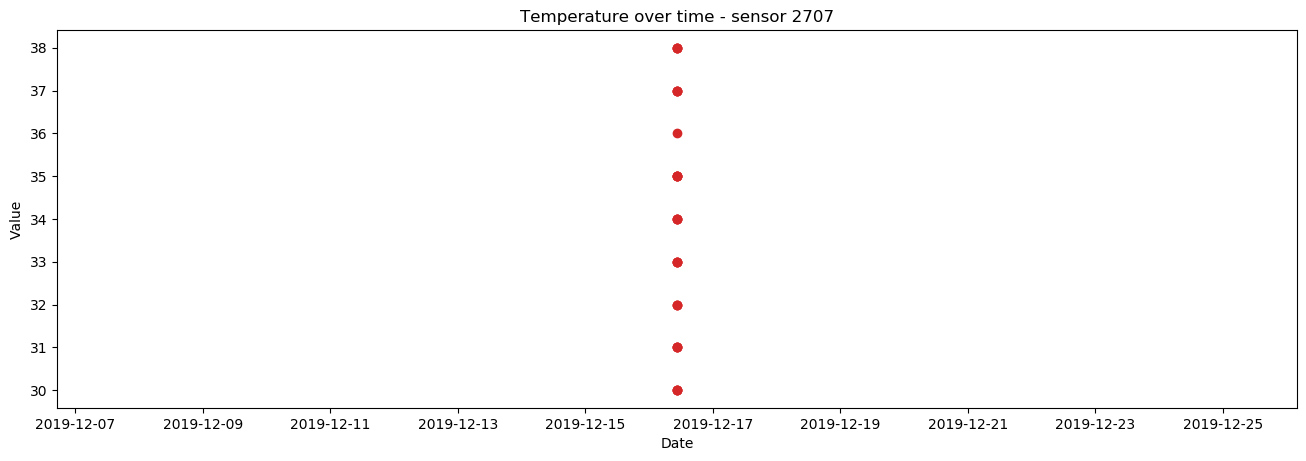

In [101]:
%local

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Basic plot
def plot_df(dataFrame, x1, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.scatter(x1, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(device, x1=device.time, y=device.temperature, title='Temperature over time - sensor '+str(deviceID))    

It could be useful to compare the temperature measured by the sensor with the power production over time. Is the temperature raising over time? Does an increase in power production implies an increase in temperature? With some lag?

Note that the data generator we used here doesn't provide very meaningful data regarding Physics... Furthermore, we would need a far longer observation time to make any conclusion. However, the following visualisations are provided for the sake of our use case.

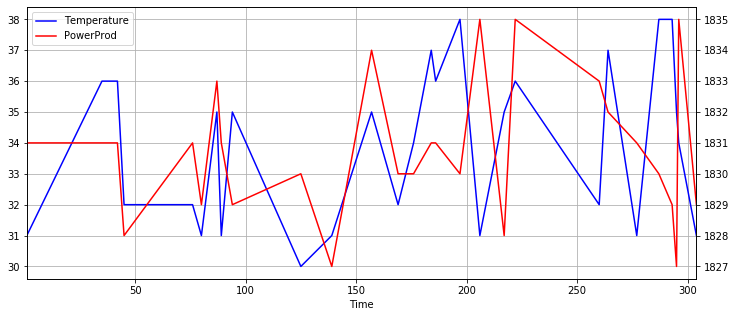

In [84]:
%local

# Temperature and power production over time 
# in a particular sensor

plt.figure(figsize=(12,5))
plt.xlabel('Time')

ax1 = device.temperature.plot(color='blue', grid=True, label='Temperature')
ax2 = device.powerProd.plot(color='red', grid=True, secondary_y=True, label='PowerProd')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()